In [1]:
import json
import pandas as pd
from typing import DefaultDict, List
import numpy as np
import seaborn as sns
import logging

In [7]:
class Node:

    def __init__(self, genome_id, loss, generation):
        self.genome_id = genome_id
        self.loss = loss
        self.generation = generation
        self.children = []
        self.parents = []

    def add_child(self, child_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, self, child_node)
        self.children.append(con)

    def add_parent(self, parent_node, edge_name, edge_params):
        con = Edge(edge_name, edge_params, parent_node, self)
        self.parents.append(con)

class Edge:

    def __init__(self, name, params, parent, child):
        self.name = name
        self.params = params
        self.parent = parent
        self.child = child

class Nodes:

    def __init__(self):
        self.nodes = {}

    def add_node(self, node):
        self.nodes[node.genome_id] = node

    def has_node_id(self, node_id):
        return node_id in self.nodes.keys()

    def get_node(self, node_id):
        return self.nodes[node_id]
    
    def get_generation(self, i_generation):
        return list(filter(lambda x:x.generation==i_generation, self.nodes.values()))

    def get_all_edges(self):
        for node in self.nodes.values():
            for edge in node.children:
                yield edge

    def connect(self, nodeid_parent, nodeid_child, edge_name, edge_params):
        parent = self.get_node(nodeid_parent)
        child = self.get_node(nodeid_child)
        parent.add_child(child, edge_name, edge_params)
        child.add_parent(parent, edge_name, edge_params)

def build_graph(infile):
    generation_counter = 0
    nodes = Nodes()
    num_errors = 0
    for line in open(infile):
        try:
            data = json.loads(line)
        except Exception as e:
            num_errors += 1
            if num_errors >= 3:
                break
            logging.error(e)
            continue
        for i in range(len(data["genome_ids"])):
            node = Node(
                data["genome_ids"][i], 
                data["losses"]["total"][i],
                generation_counter
            )
            nodes.add_node(node)
        generation_counter += 1

        mo = data["mutations_operations"]
        if len(mo)>0:
            for i in range(len(mo["operation"])):
                father_id = mo["father_id"][i]
                child_id = mo["child_id"][i]

                if nodes.has_node_id(child_id) and nodes.has_node_id(father_id):
                    nodes.connect(
                        father_id,
                        child_id,
                        mo["operation"][i],
                        {}
                    )

        co = data["crossover_operations"]
        if len(co)>0:
            for i in range(len(co["operation"])):
                parent1 = co["parent1_genome"][i]
                parent2 = co["parent2_genome"][i]
                child_id = co["child_id"][i]
                if nodes.has_node_id(child_id) and nodes.has_node_id(parent1) and nodes.has_node_id(parent2):
                        nodes.connect(
                            parent1,
                            child_id,
                            co["operation"][i],
                            {}
                        )
                        nodes.connect(
                            parent2,
                            child_id,
                            co["operation"][i],
                            {}
                        )
    return nodes

infile = '../../../evolutions/2024-04-06T11-20-41_evolve_arusha/evolution_operations.jsonl'
nodes = build_graph(infile)
deltas = []
for edge in nodes.get_all_edges():
    loss_delta = edge.parent.loss - edge.child.loss
    deltas.append([edge.name, np.max((0, loss_delta))])
deltas = pd.DataFrame(deltas, columns=["operation", "delta"])
deltas

{"genome_ids": [69, 194, 193, 178, 37, 39, 108, 140, 19, 6, 141, 33, 68, 175, 191, 14, 24, 45, 147, 76, 42, 164, 55, 82, 123, 124, 64, 109, 172, 177, 137, 10, 89, 136, 5, 57, 70, 75, 32, 44, 173, 9, 84, 185, 143, 134, 22, 184, 118, 150, 56, 121, 77, 53, 112, 132, 79, 58, 34, 11, 135, 190, 171, 47, 197, 35, 144, 200, 13, 27, 165, 162, 176, 126, 182, 119, 187, 16, 4, 48, 151, 106, 20, 114, 169, 145, 61, 110, 160, 60, 149, 168, 95, 189, 17, 83, 192, 199, 103, 198, 148, 73, 94, 7, 179, 157, 63, 72, 180, 36, 74, 116, 152, 81, 8, 28, 38, 1, 78, 113, 131, 138, 105, 25, 122, 59, 107, 186, 127, 104, 88, 3, 170, 80, 133, 128, 130, 21, 31, 85, 125, 51, 15, 65, 2, 30, 90, 97, 161, 167, 62, 52, 196, 12, 156, 66, 54, 154, 92, 50, 99, 100, 102, 96, 43, 93, 115, 139, 153, 146, 111, 120, 86, 155, 188, 183, 101, 26, 129, 158, 46, 91, 98, 87, 40, 159, 67, 163, 181, 174, 49, 71, 195, 166, 29, 41, 23, 142, 117, 18], "genomes": [[0.25384549123278366, 0.9345519606677232, 0.10101581619957756, 0.56913050383846

JSONDecodeError: Expecting ',' delimiter: line 1 column 17256 (char 17255)

In [9]:

line[17250:17260]


'82965"3987'

In [5]:
infile

'../../../evolutions/2024-04-06T11-20-41_evolve_arusha/evolution_operations.jsonl'

<AxesSubplot: xlabel='operation', ylabel='delta'>

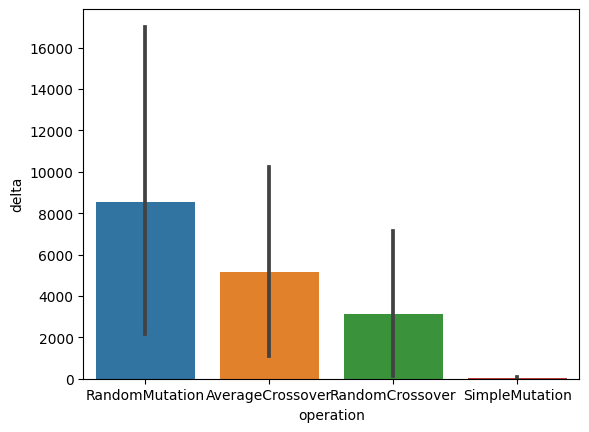

In [73]:
sns.barplot(data=deltas, x="operation", y="delta")

In [1]:
deltas.query("delta>0")

NameError: name 'deltas' is not defined

In [50]:
infile = "../../../evolutions/2024-04-06T11-20-41_evolve_arusha/evolution_operations.jsonl"
i=0
data = []
gens = {}
for line in open(infile):
    data = json.loads(line)
    if 202 in data["genome_ids"]:
        print(i)
    for gid in data["genome_ids"]:
        gens[gid] = i
    i+=1


In [47]:
202 in gens.keys()

False

In [36]:
for i in range(len(mo["operation"])):
    father_id = mo["father_id"][i]
    child_id = mo["child_id"][i]
    
    assert father_id in data[0]["genome_ids"]
    print(child_id)
    assert child_id in data[1]["genome_ids"]


201
202


AssertionError: 

In [44]:
FOR 

False

In [15]:
data["crossover_operations"]

{}

df.

In [15]:
for key, value in data.items():
    print(key, len(value))

genome_ids 5
genomes 5
losses 5
mutations_operations 5
crossover_operations 5
date 5
0 0


In [14]:
df = pd.DataFrame(data)
df

ValueError: All arrays must be of the same length

README.md        evolutions       src
assets           saved_evolutions
